## TP Ajustement de faisceaux / "Bundle Adjustment"

Guillaume Bourmaud

L'objectif de ce TP est d'implémenter un **ajustement de faisceaux entre deux caméras**. Nous nous placerons dans le cas où :
- les correspondances disponibles ont été pré-filtrées et ne contiennent donc pas de correspondance erronnée,
- une "bonne" initialisation des poses des caméras et des points 3D est disponible, de telle sorte que l'ajustement de faisceaux ne tombe pas dans un mauvais minimum local.
  
Ainsi, comme nous l'avons vu en cours, la fonction de coût à minimiser sera la somme des erreurs de reprojection au carré.

Dans ce TP, il est demandé de réaliser une implémentation naïve, c'est à dire de créer une matrice jacobienne dense et de la remplir, à chaque itération. Une telle implémentation sera peu efficace car la matrice jacobienne est parcimonieuse (elle contient beaucoup de zéros). En pratique, on considère généralement le [complément de Schur](https://en.wikipedia.org/wiki/Schur_complement) pour obtenir une [implémentation efficace](https://www.isprs.org/proceedings/XXXVI/part3/singlepapers/O_24.pdf) mais ce n'est pas l'objectif de ce TP. 

**Les données à traiter sont disponibles [ici](https://gbourmaud.github.io/files/vision/TP/TP_bundle_adjustment/data_ready.pkl).**

## Chargement des données
Le code suivant permet de charger ces données est d'afficher l'erreur de reprojection.

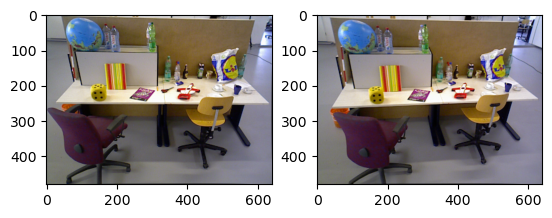

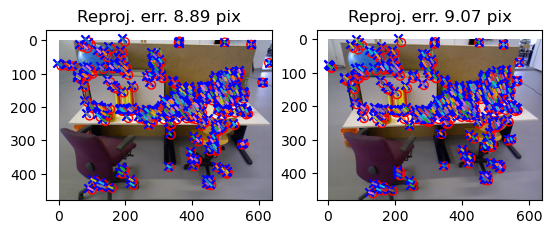

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

#Load images, tracks, initial camera poses and 3D point cloud
with open('data_ready.pkl', 'rb') as f:
    p_list = pickle.load(f) 
    p = [np.array(pi) for pi in p_list] #kpts
    Uw = np.array(pickle.load(f)) #3D point cloud initialization
    K = np.array(pickle.load(f)) # camera calibration matrix
    Mwc_list = pickle.load(f) # camera poses
    Mwc = [np.array(Mwi) for Mwi in Mwc_list]
    tracks_list = pickle.load(f) # tracks
    tracks = [{'p3D_ids':np.array(tracks_i['p3D_ids']),'p2D_ids':np.array(tracks_i['p2D_ids'])}  for tracks_i in tracks_list]
    I_list = pickle.load(f) # images
    I = [np.array(Ii) for Ii in I_list] 


fig1, axs1 = plt.subplots(1,2)
axs1[0].imshow(I[0]);
axs1[1].imshow(I[1]);

nCam = len(Mwc)

fig2, axs2 = plt.subplots(ncols=nCam)
for cam in range(nCam):
    Mwc_cur = Mwc[cam]
    U_c = (Uw[tracks[cam]['p3D_ids'],:] - Mwc_cur[:3,3])@Mwc_cur[:3,:3]
    p_c_pred = (U_c/U_c[:,2:3]) @ K.T
    p_c = p[cam][tracks[cam]['p2D_ids'],:]
     
    reproj_error = (1/p_c_pred.shape[0])*np.sqrt(((p_c_pred - p_c)**2).sum(axis=1)).sum()
    
    axs2[cam].imshow(I[cam])
    axs2[cam].scatter(p_c[:,0], p_c[:,1], marker ='o', facecolors='none', edgecolors='r')
    axs2[cam].scatter(p_c_pred[:,0], p_c_pred[:,1], marker ='x', color='b')
    axs2[cam].plot(np.vstack((p_c[:,0],p_c_pred[:,0])), np.vstack((p_c[:,1],p_c_pred[:,1])))
    axs2[cam].set_title('Reproj. err. {0:0.2f} pix'.format(reproj_error))

plt.pause(0.1)

## Ajustement de faisceaux

Afin d'implémenter l'algorithme de Levenberg-Marquardt dans le but de minimiser l'erreur de reprojection, il est conseillé d'implémenter une classe. Vous trouverez ci-après un exemple d'implémentation.

In [1]:
import sys
import numpy as np
import scipy as sp
import math
from scipy.spatial.transform import Rotation as R
import copy

class BA_LM_two_views():
    
    def __init__(self,  Mwc_init, Uw_init, tracks, K, p, maxIt=1000, lambdaMin=1e-5, lambdaMax=1e5, lambdaInit = 1e-3):
        self.lambdaInit = lambdaInit
        self.lambdaMin = lambdaMin
        self.lambdaMax = lambdaMax
        self.maxIt = maxIt
        
        self.K = K.copy()
        self.p = copy.deepcopy(p)
        self.tracks = copy.deepcopy(tracks)
        
        if(len(Mwc_init)!=2):
            print("Only two view BA is implemented")
            sys.exit()
            
        self.nCam = len(Mwc_init)
        
        self.Rwc = [Mwc_init[i][:3,:3].copy() for i in range(self.nCam)]
        self.twc = [Mwc_init[i][:3,3].copy() for i in range(self.nCam)] 
        self.Uw = Uw_init.copy()
        self.nP3D = self.Uw.shape[0]
        

        self.lambda_cur = lambdaInit
        
        self.J = np.zeros((2*2*self.nP3D, 6*self.nCam+3*self.nP3D)) #inefficient, in practice we should not create this dense matrix, and use the Schur Complement instead

    def getPoses(self):
        Mcw = []
        for i in range(self.nCam):
            Mcw_temp = np.eye(4)
            Mcw_temp[:3,:3] = self.Rwc[i]
            Mcw_temp[:3,3] = self.twc[i]
            Mcw.append(Mcw_temp)
        return Mcw
    
    def getPointCloud(self):
        return self.Uw
    
    def compute_residuals(self):
                    
        r_list = []
        for i in range(self.nCam):
            p_vis = self.p[i][self.tracks[i]['p2D_ids'],:]
            
            Ui = (self.Uw[self.tracks[i]['p3D_ids'],:] - self.twc[i])@(self.Rwc[i])
            p_vis_pred_hom = (Ui/Ui[:,2:3]) @ self.K.T
            p_vis_pred = p_vis_pred_hom[:,:2]
            
            r_list.append(p_vis[:,:2].flatten() - p_vis_pred.flatten())

        r = np.hstack(r_list)
        return r

    def compute_cost(self):
        
        r = self.compute_residuals()
        c = (r**2).sum()

        n_res= sum(self.tracks[i]['p2D_ids'].shape[0] for i in range(self.nCam))
        c_in_pix = math.sqrt(c/n_res); #RMSE in pixels
        return c_in_pix
    
    def generators_SO3(self):
        Gx = np.array([[0.,  0., 0.],[0., 0., -1.],[ 0., 1., 0.]])
        Gy = np.array([[0.,  0., 1.],[0., 0.,  0.],[-1., 0., 0.]])
        Gz = np.array([[0., -1., 0.],[1., 0.,  0.],[ 0., 0., 0.]])
        return Gx, Gy, Gz
    
    
    def expSO3(self, w): #matrix exponential for 3D roations
        return R.from_rotvec(w).as_matrix()
    
    def compute_Jacobian(self):
               
           
       Gx, Gy, Gz = self.generators_SO3()

       ####################################### 
       #TODO COMPUTE JACOBIAN -> FILL self.J
       ####################################### 
       
       return

    def updateParameters(self, r, c_prev, iteration):
        
        success = False
        
        
        while(self.lambda_cur<self.lambdaMax):
            
            

            #solve linear system : inefficient, in practice we should consider the Schur complement instead
            delta = sp.linalg.solve(self.J.T@self.J + self.lambda_cur*np.eye(3*self.nP3D + 6*self.nCam), self.J.T@r,assume_a='sym')

            #update variables
            Uw_prev = self.Uw.copy()
            self.Uw  += np.reshape(delta[6*self.nCam:],(self.nP3D,3))
            
            Rwc_prev = copy.deepcopy(self.Rwc)
            twc_prev = copy.deepcopy(self.twc)
            for cam in range(self.nCam):                
                self.Rwc[cam] = self.Rwc[cam]@self.expSO3(delta[6*cam:3+6*cam])
                self.twc[cam] += delta[3+6*cam:6+6*cam]
 
            #compute cost
            c_new = self.compute_cost()
            print('Iter:{} Error:{} pix Lambda:{}'.format(iteration,c_new,self.lambda_cur))

            if(c_new+1e-5) < c_prev:
                success = True
                #print('c new {}, c prev {} ,success {}'.format(c_new, c_prev, success))
                if self.lambda_cur>self.lambdaMin :
                    self.lambda_cur /= 2
                break
            else:
                self.lambda_cur *= 2
                self.Rwc = Rwc_prev
                self.twc = twc_prev
                self.Uw = Uw_prev

        if not success:
            c_new = c_prev
        
        return c_new, success

    def optimize(self):
        
        
        #compute inital cost
        c = self.compute_cost()
    
        print('Iter:{} Error:{} pix'.format(0,c))
                
        for i in range(self.maxIt):
            
            #compute Jacobian and residuals
            r = self.compute_residuals()
            self.compute_Jacobian()
            
            #update parameters
            c, success = self.updateParameters(r, c, i)
            
            if not success:
                break  

        return

**Travail à effectuer : compléter la méthode `compute_Jacobian`, l'expression de la matrice jacobienne est disponible [ici](https://gbourmaud.github.io/files/vision/TP/TP_bundle_adjustment/expression_jacobienne.pdf).**

Une implémentation correcte devrait vous fournir le résultat suivant :

Iter:0 Error:9.244311964477996 pix
Iter:0 Error:0.5204361679042591 pix Lambda:0.001
Iter:1 Error:0.20789087483188332 pix Lambda:0.0005
Iter:2 Error:0.20787414144944535 pix Lambda:0.00025
Iter:3 Error:0.20787414111795735 pix Lambda:0.000125
Iter:3 Error:0.20787414111795688 pix Lambda:0.00025
Iter:3 Error:0.2078741411179591 pix Lambda:0.0005
Iter:3 Error:0.2078741411179578 pix Lambda:0.001
Iter:3 Error:0.20787414111795932 pix Lambda:0.002
Iter:3 Error:0.20787414111796207 pix Lambda:0.004
Iter:3 Error:0.20787414111796737 pix Lambda:0.008
Iter:3 Error:0.20787414111798008 pix Lambda:0.016
Iter:3 Error:0.20787414111800992 pix Lambda:0.032
Iter:3 Error:0.20787414111808625 pix Lambda:0.064
Iter:3 Error:0.20787414111824648 pix Lambda:0.128
Iter:3 Error:0.20787414111853547 pix Lambda:0.256
Iter:3 Error:0.20787414111897964 pix Lambda:0.512
Iter:3 Error:0.20787414111968744 pix Lambda:1.024
Iter:3 Error:0.20787414112117583 pix Lambda:2.048
Iter:3 Error:0.20787414112498032 pix Lambda:4.096
Iter:3 Er

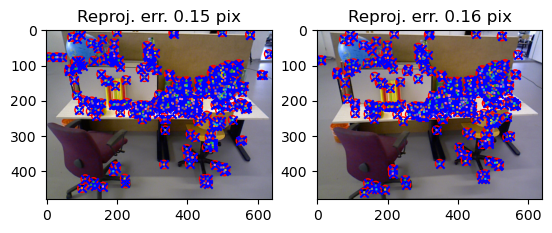

In [3]:
BA = BA_LM_two_views(Mwc, Uw, tracks, K, p)
BA.optimize()
Mcw_opt = BA.getPoses()
Uw_opt = BA.getPointCloud()

fig3, axs3 = plt.subplots(ncols=nCam)
for cam in range(nCam):
    Mwc_cur = Mcw_opt[cam]
    U_c = (Uw_opt[tracks[cam]['p3D_ids'],:] - Mwc_cur[:3,3])@Mwc_cur[:3,:3]
    p_c_pred = (U_c/U_c[:,2:3]) @ K.T
    p_c = p[cam][tracks[cam]['p2D_ids'],:]
     
    reproj_error = (1/p_c_pred.shape[0])*np.sqrt(((p_c_pred - p_c)**2).sum(axis=1)).sum()
    
    axs3[cam].imshow(I[cam])
    axs3[cam].scatter(p_c[:,0], p_c[:,1], marker ='o', facecolors='none', edgecolors='r')
    axs3[cam].scatter(p_c_pred[:,0], p_c_pred[:,1], marker ='x', color='b')
    axs3[cam].plot(np.vstack((p_c[:,0],p_c_pred[:,0])), np.vstack((p_c[:,1],p_c_pred[:,1])))
    axs3[cam].set_title('Reproj. err. {0:0.2f} pix'.format(reproj_error))

plt.pause(0.1)